__Group Name__ : __Data Dynamo__
1. Roy, Abhijith; `abhijithroy.roy@carelon.com`,
2. Acharya, Ananth; `ananth.acharya@carelon.com`; 
3. Kumar, Diwakar; `diwakar.kumar@carelon.com`; 
4. Gouse, Mohammad; `mohammad.gouse@carelon.com`;
5. Peketi, Santhosh; `santhosh.peketi@carelon.com`, 

# Soft Prompting using GPT-2 on Machine Translation (EN->DE)

### Questions
__1. Concept of Soft Prompts__: <br>
How does the introduction of ”soft prompts” address the limitations of discrete 
text prompts in large language models? Why might soft prompts be 
considered a more flexible and efficient approach for task-specific 
conditioning? <br> <br>
__2. Scaling and Efficiency in Prompt Tuning__: <br>
How does the efficiency of prompt tuning relate to the scale of the language 
model? Discuss the implications of this relationship for future developments
in large-scale language models and their adaptability to specific tasks.

### Answers : 
__1. Concept of Soft Prompts__ <br>
- Soft prompts are a novel approach to prompt engineering that involves incorporating vectors into an input sequence and then fine-tuning these vectors while keeping the rest of the pre-trained model’s components unchanged
- Unlike traditional human-readable prompts, which provide clear instructions expressed in human languages, soft prompts involve incorporating vectors that are very much abstract and random. Therefore, even though these vectors guide the model’s behavior, their non-linguistic nature makes it very hard for humans to understand them.
- Soft prompts are considered a more flexible and efficient approach for task-specific conditioning because they allow for more fine-grained control over the model’s behavior and can be adapted to a wide range of tasks 1.

__2. Scaling and Efficiency in Prompt Tuning__ <br>
- The efficiency of prompt tuning is directly related to the scale of the language model. As the size of the model increases, prompt tuning becomes more competitive with model tuning
- In other words, larger models can be more efficiently fine-tuned using soft prompts than smaller models. This has important implications for future developments in large-scale language models and their adaptability to specific tasks. By leveraging the power of scale, prompt tuning can help to improve the performance of machine learning models without requiring extensive reprogramming or retraining
- However, it is important to find the right balance between model size and prompt tuning performance, as scaling affects prompt tuning like a tailored suit—too loose, and it won’t hold; too tight, and it restricts movement

## Loading required packages and importing GPT2 model through torch

In [1]:
#importing required libraries for the task.....
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import nltk
from nltk.translate.bleu_score import sentence_bleu

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer,AdamW
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset
from tqdm import tqdm
import wandb

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
np.object = object

## Loading the Dataset - Europarl-ST

In [3]:
#reading dataset from csv file......
dataset = pd.read_csv('/kaggle/input/europarl-english-german/Europarl_en-de.csv')

## Exploratory Data Analysis with Preprocessing of the dataset

In [4]:
#sample view of dataset.....
dataset.head(3)

,English,German
0,Resumption of the session,Wiederaufnahme der Sitzungsperiode
1,I declare resumed the session of the European ...,"Ich erkläre die am Freitag, dem 17. Dezember u..."
2,"Although, as you will have seen, the dreaded '...","Wie Sie feststellen konnten, ist der gefürchte..."


In [5]:
#removing nulls.....
dataset = dataset.dropna()

In [6]:
#Total number of samples in dataset....
print(f"Number of Samples in dataset : {len(dataset)}")

Number of Samples in dataset : 1908920


In [7]:
#sampling dataset with .2% of whole data for model training and validation....
sample_df = dataset.sample(frac=.002,random_state=42)

In [8]:
#sample view of partitioned dataset.....
sample_df.head()

,English,German
542843,Combined with your youth and your love of parl...,"Ich denke, dass Ihr zentraler Ansatz sein müss..."
1158425,"As we all know, Portugal applied to the Europe...","Wie wir alle wissen, hat Portugal dieses Geld ..."
640379,You are not going to finance the planes that f...,"Sie weigern sich, den Flugzeugen, die zu den v..."
576243,This means funding for projects with a depress...,"Das heißt, Projekte werden mit einer restrikti..."
603872,An improved environment will generally also ha...,Ein besseres Umfeld wird sich günstig auf die ...


In [9]:
#creating train test split for dataset.......
train_df,test_df = train_test_split(sample_df,test_size=.25,random_state=42)

In [10]:
#Number of samples in train and test set.....
print(f"Number of samples in train dataset : {len(train_df)}")
print(f"Number of samples in test dataset : {len(test_df)}")

Number of samples in train dataset : 2863
Number of samples in test dataset : 955


## Loading the GPT-2 Tokenizer + Defining prompt for Translation (EN->DE)

In [11]:
# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
#prompt tokens....
#prompt we are going to add....
prompt = "[TRANSLATE EN DE]"
prompt_tokens = tokenizer.tokenize(prompt)
print(f"Tokenized prompt : {prompt_tokens}")
print(f"Number of tokens in prompt : {len(prompt_tokens)}")

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Tokenized prompt : ['[', 'TR', 'AN', 'SL', 'ATE', 'ĠEN', 'ĠDE', ']']
Number of tokens in prompt : 8


## Tokenization and Padding input and outputs

In [12]:
#method for tokenization and padding inputs and outputs.....
def tokenize_pad(input_data,output_data):
    input_ids = []
    output_ids  = []
    for input_,output in zip(input_data,output_data):
        tokenized_input = tokenizer.encode(input_,padding='max_length',max_length=1016)
        tokenized_output = tokenizer.encode(output,padding='max_length',max_length=1024)
        
        if len(tokenized_input) >=1 and len(tokenized_output) >= 1:
            input_ids.append(torch.tensor(tokenized_input[:1016]))
            output_ids.append(torch.tensor(tokenized_output[:1024]))
            
    return input_ids,output_ids

In [13]:
#tokenizing and padding accordingly......
train_input_ids,train_output_ids = tokenize_pad(train_df['English'],train_df['German'])
valid_input_ids,valid_output_ids = tokenize_pad(test_df['English'],test_df['German'])

In [14]:
#snapshot after tokenization....
tokenizer.decode(train_input_ids[0][:31])

"We referred extensively to the agenda for the Thessaloniki Council at this morning's debate.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>"

In [15]:
#snapshot after tokenization.....
tokenizer.decode(train_output_ids[0][:60])

'Auf die Tagesordnung des Rates von Thessaloniki sind wir in der Debatte am Vormittag ausführlich eingegangen.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [16]:
#checking if every sample is in same dimensions.....
def check_tokens(tokens,dim=1024):
    for tok in tokens:
        if tok.shape[0]!=dim:
            return False
    return True

In [17]:
check_tokens(train_input_ids,1016),check_tokens(valid_input_ids,1016),check_tokens(train_output_ids),check_tokens(valid_output_ids)

(True, True, True, True)

## Defining the Soft Prompt Architecture

In [18]:
#pretrained GPT-2 model....
model_name = "gpt2"
gpt2_model = GPT2LMHeadModel.from_pretrained(model_name)


# Define the number of prompts and embedding size
num_prompts = 8  # "summarize the following text"
embedding_size = 768

# Create an embedding layer for soft prompts and initialize with the sentence embeddings
soft_prompt_embeddings = nn.Embedding(num_prompts, embedding_size)

# Concatenate soft prompt embeddings at the beginning of the input sequence
class GPT2WithPromptTuning(nn.Module):
    def __init__(self, gpt2_model, soft_prompt_embeddings):
        super(GPT2WithPromptTuning, self).__init__()
        self.gpt2_model = gpt2_model
        self.soft_prompt_embeddings = soft_prompt_embeddings
    
    def forward(self, input_ids, soft_prompt_ids):
        # Get the embeddings for the input_ids from the GPT-2 model
        gpt2_embeddings = self.gpt2_model.transformer.wte(input_ids)
        # Get the embeddings for the soft prompts
        soft_prompt_embeds = self.soft_prompt_embeddings(soft_prompt_ids)
        
        # Concatenate the embeddings
        embeddings = torch.cat([soft_prompt_embeds, gpt2_embeddings], dim=0)
        # Pass the concatenated embeddings through the GPT-2 model
        outputs = self.gpt2_model(inputs_embeds=embeddings)
    
        return outputs

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## Freezing GPT-2 model weights

In [19]:
# Initialize the model
model = GPT2WithPromptTuning(gpt2_model, soft_prompt_embeddings)

# Freeze GPT-2 model weights
for param in model.gpt2_model.parameters():
    param.requires_grad = False

# Define hyperparameters
epochs = 10
learning_rate = 2e-5
gradient_clip_value = 1.0

# Define optimizer and criterion
optimizer = torch.optim.AdamW(model.soft_prompt_embeddings.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

#token ids for softprompt...
soft_prompt_ids = torch.tensor([0, 1, 2, 3 ,4 ,5,6,7])

## Training the model 

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU
model.to(device)

# Define device (assuming you have a CUDA-enabled GPU)

# Move optimizer and criterion to GPU
optimizer = torch.optim.AdamW(model.soft_prompt_embeddings.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=-100).to(device)

# Initialize Weights and Biases
wandb.init(project='SoftPrompt on GPT-2 for Summarization', name = "Europarl-Translation", config={'learning_rate': learning_rate})
model.train()
# Training loop
for epoch in range(epochs):
    # Create a tqdm progress bar for the training data
    data_iterator = tqdm(zip(train_input_ids,train_output_ids), desc=f'Epoch {epoch + 1}', total=len(train_input_ids))
    train_blu = []
    for input_ids, target_ids in data_iterator:
        optimizer.zero_grad()

        # Move input and target tensors to GPU
        input_ids, target_ids = input_ids.to(device), target_ids.to(device)
        
        # Assuming you have a soft_prompt_ids for each training instance
        # If not, you might need to modify this part accordingly
        outputs = model(input_ids, soft_prompt_ids.to(device))
        logits = outputs.logits if hasattr(outputs, "logits") else outputs.last_hidden_state
        
        # Create a mask to ignore padding tokens
        pad_mask = (target_ids != 50256)

        # Flatten the logits and target_ids while ignoring padding tokens
        flattened_logits = logits.view(-1, logits.size(-1))[pad_mask.view(-1)]
        flattened_target_ids = target_ids.view(-1)[pad_mask.view(-1)]
        
        loss = criterion(flattened_logits,flattened_target_ids) 
        loss.backward()
        
        predictions = logits.argmax(dim=-1).squeeze(0).tolist()
        references = target_ids.squeeze(0).tolist()
        
        # BLEU Score
        tr_blu = sentence_bleu([references], predictions)
        train_blu.append(tr_blu)
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_value)
        
        optimizer.step()

        # Update the progress bar description with the current loss
        data_iterator.set_postfix({'Training Loss' : loss.item()})
    
#     # Validation loop
    model.eval()
    val_losses = []
    bleu_score = []
    with torch.no_grad():
        for input_ids_val, target_ids_val in zip(valid_input_ids,valid_output_ids):
            input_ids_val, target_ids_val = input_ids_val.to(device), target_ids_val.to(device)
            outputs_val = model(input_ids_val, soft_prompt_ids.to(device))
            logits_val = outputs_val.logits if hasattr(outputs_val, "logits") else outputs_val.last_hidden_state
            # Create a mask to ignore padding tokens
            pad_mask = (target_ids_val != 50256)

            # Flatten the logits and target_ids while ignoring padding tokens
            flattened_logits_val = logits_val.view(-1, logits.size(-1))[pad_mask.view(-1)]
            flattened_target_ids_val= target_ids_val.view(-1)[pad_mask.view(-1)]
            
            
            loss_val = criterion(flattened_logits_val,flattened_target_ids_val)
            val_losses.append(loss_val.item())
            # Convert tensor predictions and references to lists
            predictions = logits_val.argmax(dim=-1).squeeze(0).tolist()
            references = target_ids_val.squeeze(0).tolist()

            # BLEU Score
            blu = sentence_bleu([references], predictions)
            bleu_score.append(blu)
    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_val_bl   = sum(bleu_score) / len(bleu_score)
    avg_tr_bl    = sum(train_blu) / len(train_blu)
    
    data_iterator.set_postfix({"Validation Loss" : avg_val_loss})
    wandb.log({"epoch": epoch + 1, "train_loss": loss.item(), "train_bleu" : avg_tr_bl ,"val_loss": avg_val_loss,"val_bleu_score" : avg_val_bl})

    # Set the model back to training mode
    model.train()

# Close the tqdm progress bar
data_iterator.close()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1:   0%|          | 0/2863 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Epoch 1:   2%|▏         | 57/2863 [00:09<06:56,  6.74it/s, Training Loss=13.5]/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Epoch 10: 100%|██████████| 2863/2863 [07:04<00:00,  6.74it/s, Training Loss=10.1]


## Results and Plots

In [22]:
wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
train_bleu,█▇▇▇▅▆▄▂▂▁
train_loss,█▇▅▆▅▅▅▃▃▁
val_bleu_score,█▆▁▂▂▃▄▅▄▄
val_loss,█▇▇▆▅▅▄▄▃▁
epoch,10
train_bleu,0.22115
train_loss,10.08503
val_bleu_score,0.22061
val_loss,10.53931


### Legends
Orange -- Training BLEU Score, Blue -- Validation BLEU Score


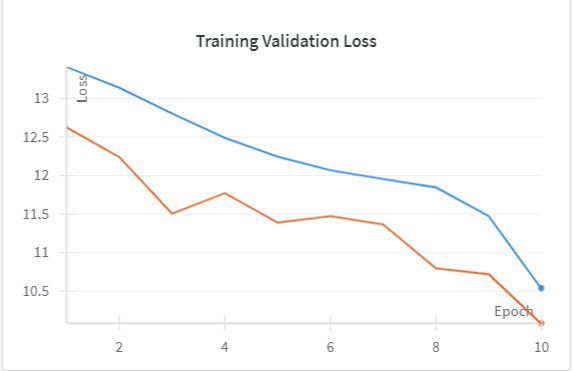

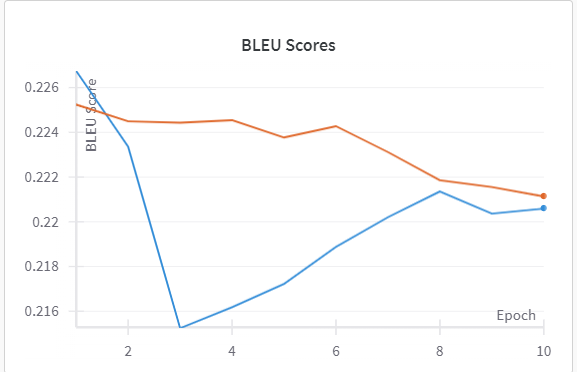

## Inferences from the results and plots
> Training and Validation Loss
>- Training and Validation loss curves are continually decreasing indicating further learning (more number of epochs)


> BLEU Scores
>- BLEU scores are an average of unigram, bigram, trigram, 4-gram precision scores with the added penalty for brevity.
>-  When compared to the other fine-tuning tasks such as __Summarization__ and __Question and Answering__, BLEU scores work since it is based on precision. Machine translation tasks saturates at BLEU scores as shown above (__0.22__) that is a __below average score__.
>- This is indicative of the fact that BLEU scores do not consider __meaning and structure of the sentence__. It only rewards precision scores for n-gram matches hence why machine translation tasks have such low BLEU scores.
